# Patent Breakthrough walkthrough

This notebook illustrates the complete analysis process of breakthrough patents, from preparing input files
to calculating impact and novelty scores.

## 1. Preparing input files

There are three input files: a file with patent texts, a patent/year-index, and list of patent/CPC-codes.

### Patents
In its raw format, the input file contains the text of one patent file per line.
Each line starts with a path pointing to that patent's original text 
file (`/Volumes/External/txt/0000000-0100000/US1009.txt`), followed by the patent text. Example file: `./data/raw_input.txt`. 


### Patent/Year-index
Contains the year of publication of each patent. Example file: `./data/year.csv`. 


### CPC-file
The CPC-file (Cooperative Patent Classification) contains the patent classification code for each patent. These codes are used to calculate benchmark similarities. Example file: `./data/GPCPCs.txt`

Note: the included data files only contain a small subset of the original data, for example purposes.

#### Other files
The three other files in the data folder - `greek.txt`  `stopwords.txt`, and `symbols.txt` - are required by the `OldPreprocessor`-class.

In [2]:
from pathlib import Path

home_path = "/home/smildinerm"
storage_path = "/home/smildinerm/data/volume_2"
data_path = "/home/smildinerm/data/volume_2/data/USPTO"
input_file = Path(f"{data_path}/brief_summary")
year_file = Path(f"{data_path}/input_files/year.csv")
cpc_fp = Path(f"{data_path}/input_files/GPCPCs.txt")
patent_dir = Path(f"{storage_path}/patents")
output_folder = Path(f"{home_path}/output")
output_fp = Path(f"{home_path}/output", "patents.h5")
results_fp = Path(f"{home_path}/results")

output_folder.mkdir(exist_ok=True)
patent_dir.mkdir(exist_ok=True)

### 1.1. Compressing

The compressor function transforms the patents to a more manageable format, sorts and saves them by year of publication, and compresses the resulting files.

In [3]:
import json
import lzma
import re
from typing import List, Union, Dict
from pathlib import Path
from collections import Counter, defaultdict
from tqdm import tqdm
import os
import csv
import glob
import multiprocessing

def read_xz(compressed_fp: Union[Path, str]) -> List[Dict]:
    """Read an .xz file containing patents

    Arguments
    ---------
    compressed_fp:
        File to read the patents from.

    Results
    -------
    patents: List[Dict]
        Patents in the file.
    """
    with lzma.open(compressed_fp, mode="rb") as handle:
        patents = json.loads(handle.read().decode(encoding="utf-8"))
    return patents

def write_xz(compressed_fp: Union[Path, str], patents: List[Dict]) -> None:
    """Write a set of patents to a compressed file

    Arguments
    ---------
    fp:
        File to write to.
    patents:
        Patents to store.
    """
    with lzma.open(compressed_fp, mode="wb", preset=9) as handle:
        handle.write(str.encode(json.dumps(patents), encoding="utf-8"))

def parse_patent_file(patent_input_fp: str, year_lookup: str) -> List[Dict[str, str]]:
    """
    Parse a raw patent file into a structured list.

    Parameters:
    -----------
    patent_input_fp : str
        Path to the .tsv input file to process with columns 'patent_id' and 'summary_text', one patent per row.

    year_lookup : str
        Path to the .csv file to lookup the year for each patent ID with columns 'pat' (patient_id) and 'year'.

    Returns:
    --------
    List[Dict[str, str]]
        A sorted list of dictionaries, where each item is for one patent and
        the year of publication:
        {
            'patent': patent_id,
            'file': file name,
            'contents':  summary_text,
            'year': year
        }
    """
    
    print(f"Starting to parse file {patent_input_fp}.\n")
    
    # Increase the field size limit
    csv.field_size_limit(10**8)
    
    # Initialize an empty list to store the structured patent data
    patents = []

    # Read the year lookup data into a dictionary for quick access
    year_dict = {}
    with open(year_lookup, 'r', newline='') as year_file:
        year_reader = csv.DictReader(year_file, delimiter='\t')
        for row in year_reader:
            year_dict[row['pat']] = row['year']  # Convert 'year' to integer

    # Extract year from the filename
    year = str(patent_input_fp).split('_')[-1].split('.')[0]

    # Read the raw patent file and parse the data
    with open(patent_input_fp, 'r', newline='') as patent_file:
        patent_reader = csv.DictReader(patent_file, delimiter='\t')
        for row in tqdm(patent_reader):
            patent_id = row['patent_id']
            
            # Skip entries where "patent_id" is not an integer
            if not patent_id.isdigit():
                continue

            # Skip entries where "patent_id" is not in year_file:
            if patent_id not in year_dict:
                continue

            summary_text = row['summary_text']
            # year = year_dict.get(patent_id, None)

            # Create a dictionary for the current patent
            patent_data = {
                'patent': int(patent_id),  # Convert 'patent_id' to integer
                'file': str(patent_input_fp),
                'contents': summary_text,
                'year': int(year)
            }

            # Append the patent data to the list
            patents.append(patent_data)
    
    patents = sorted(patents, key=lambda x: x["patent"])
    
    return patents

def compress_raw_dir(patent_input_dir: Union[Path, str], year_fp: Union[Path, str], output_dir: Union[Path, str]) -> None:
    """Compress all raw files in a directory.

    For efficiency, it stores which files have already been processed in
    a file called 'processed_files.txt' in the output directory.
    If somehow there is corruption, or re-runs are required, simply
    delete this file.

    This function is not thread-safe.

    Arguments
    ---------
    patent_input_dir:
        Directory containing all raw files with patents.
    year_fp:
        CSV file with publication year for each patent.
    output_dir:
        Directory to write the compressed files to.
    """
    patent_input_dir = Path(patent_input_dir)
    
    for file in patent_input_dir.glob("g_brf_sum_text_*.tsv"):
        
        # Extract year from the filename
        year = str(file).split('_')[-1].split('.')[0]
        
        # Get next file path to process and compress
        patent_input_fp = file
        compressed_fp = output_dir / Path(str(year) + ".xz")
        
        # Check if the output file already exists
        if os.path.exists(compressed_fp):
            print(f"Output file {compressed_fp} already exists. Skipping to the next input file.\n")
            continue

        # Parse patents for a year in the right format
        patents = parse_patent_file(patent_input_fp, year_fp)

        # Write the patents to a files, numbered by year
        write_xz(compressed_fp, patents)


def compress_and_write(patent_input_fp: Path, year_fp: Path, output_dir: Path) -> None:
    """Compresses patents from a single file and writes the compressed data to a new file.

    Arguments:
    ---------
    patent_input_fp (Path):
        Path to the input patent file.
    year_fp (Path):
        Path to the CSV file with publication year for each patent.
    output_dir (Path):
        Directory to write the compressed files to.
    """
    year = str(patent_input_fp).split('_')[-1].split('.')[0]
    compressed_fp = output_dir / Path(str(year) + ".xz")

    # Check if the output file already exists
    if os.path.exists(compressed_fp):
        print(f"Output file {compressed_fp} already exists. Skipping to the next input file.\n")
        return

    # Parse patents for a year in the right format
    patents = parse_patent_file(patent_input_fp, year_fp)

    # Write the patents to a file, compressed
    write_xz(compressed_fp, patents)


def compress_raw_dir_parallel(patent_input_dir: Union[Path, str], year_fp: Union[Path, str], output_dir: Union[Path, str], num_cores: int) -> None:
    """Compresses patents from multiple files in parallel using multiprocessing.

    Arguments:
    ---------
    patent_input_dir (Union[Path, str]):
        Directory containing all raw files with patents.
    year_fp (Union[Path, str]):
        CSV file with publication year for each patent.
    output_dir (Union[Path, str]):
        Directory to write the compressed files to.
    num_cores (int):
        Number of CPU cores to use for parallel processing.
    """
    patent_input_dir = Path(patent_input_dir)
    year_fp = Path(year_fp)
    output_dir = Path(output_dir)

    patent_files = list(patent_input_dir.glob("g_brf_sum_text_*.tsv"))

    with multiprocessing.Pool(processes=num_cores) as pool:
        pool.starmap(compress_and_write, [(file, year_fp, output_dir) for file in patent_files])



In [4]:
# Example usage:
home_path = "/home/smildinerm"
storage_path = "/home/smildinerm/data/volume_2"
data_path = "/home/smildinerm/data/volume_2/data/USPTO"

input_file = Path(f"{data_path}/brief_summary")
# input_file = Path(f"{data_path}/mock")
year_file = Path(f"{data_path}/input_files/year.csv")
cpc_fp = Path(f"{data_path}/input_files/GPCPCs.txt")
patent_dir = Path(f"{storage_path}/patents")
output_folder = Path(f"{storage_path}/output")
output_fp = Path(f"{storage_path}/output", "patents.h5")
results_fp = Path(f"{storage_path}/results")

# Parse and compress files:
compress_raw_dir_parallel(input_file, year_file, patent_dir, 20)


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1976.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1977.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1978.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1979.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1982.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1984.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1983.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1989.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1987.tsv.
Starting to parse file /home/smildinerm/data/volume_2/data/USPTO

47720it [00:05, 10114.50it/s]
57391it [00:06, 9552.44it/s]]
58279it [00:06, 9712.30it/s] 
62104it [00:06, 9659.84it/s] 
66172it [00:06, 9959.97it/s] 
65427it [00:06, 10114.30it/s]
66234it [00:06, 9535.57it/s]
67612it [00:07, 9624.84it/s]
70142it [00:06, 10112.53it/s]
71419it [00:07, 9435.19it/s]
72098it [00:07, 9398.26it/s]
83406it [00:08, 9403.64it/s]
78498it [00:08, 8864.76it/s]
90553it [00:10, 8874.17it/s]
95986it [00:10, 8839.71it/s]
96604it [00:10, 8842.05it/s]
97680it [00:11, 8677.97it/s]
102590it [00:12, 8216.27it/s]
99258it [00:11, 8375.80it/s]
102227it [00:13, 7863.11it/s]


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1996.tsv.



110401it [00:13, 8014.58it/s]


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1997.tsv.

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1999.tsv.



112703it [00:13, 8318.17it/s]
35560it [00:03, 8776.26it/s]

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_1998.tsv.



74055it [00:08, 8439.77it/s]

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2000.tsv.



154508it [00:18, 8534.18it/s]
145416it [00:17, 7825.31it/s]

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2001.tsv.



148494it [00:18, 8214.93it/s]
158772it [00:20, 7906.83it/s]


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2002.tsv.



58949it [00:07, 7747.37it/s]

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2003.tsv.



59755it [00:06, 8468.14it/s]]

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2004.tsv.



167290it [00:21, 7822.78it/s]
169033it [00:20, 8081.84it/s]
170519it [00:21, 8044.16it/s]
165712it [00:19, 8511.30it/s] 


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2005.tsv.

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2006.tsv.



144865it [00:18, 7911.96it/s]
175505it [00:22, 7693.24it/s]


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2007.tsv.



158897it [00:20, 7872.24it/s]


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2008.tsv.



159675it [00:20, 7926.03it/s]


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2009.tsv.



168915it [00:21, 8020.40it/s] 


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2010.tsv.

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2011.tsv.



221766it [00:27, 8051.91it/s]
226715it [00:28, 8089.29it/s]


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2012.tsv.



228876it [00:27, 8708.74it/s]

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2013.tsv.



255295it [00:31, 8229.06it/s]
81119it [00:09, 8080.13it/s]

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2014.tsv.



280142it [00:33, 8297.10it/s] 
303324it [00:35, 8530.86it/s] 


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2015.tsv.



300925it [00:34, 8704.40it/s] 


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2016.tsv.



305754it [00:34, 8899.10it/s] 


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2017.tsv.



321636it [00:36, 8869.72it/s] 


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2018.tsv.



310568it [00:34, 9032.84it/s] 


Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2019.tsv.

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2020.tsv.

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2021.tsv.



71705it [00:07, 9234.05it/s]]

Starting to parse file /home/smildinerm/data/volume_2/data/USPTO/brief_summary/g_brf_sum_text_2022.tsv.



357790it [00:41, 8690.21it/s] 
150625it [00:16, 8816.88it/s]
355647it [00:40, 8733.92it/s]
326228it [00:37, 8740.94it/s] 


You now have XZ-compressed files containing patents per year. Each file contains a list of JSON-objects, each JSON-object has the following key/values:

- `patent`: patent's ID
- `file`: path of original text file (not actually used)
- `contents`: patent text
- `year`: year of publication

## 2. Calculating embeddings

We calculate embeddings and scores with four different models: Countvec, Tf-Idf, Doc2Vec, and BERT ([PatentSBERTa](https://github.com/AI-Growth-Lab/PatentSBERTa)).


### 2.1. Preprocessors & parameters
Each model has its own preprocessor with various parameters. Most models also have configurable hyperparameters. The values for these parameters have been optimised using the original dataset, resulting in the values used in the `compute_embeddings()`-function below.

To recalibrate preprocessor and model parameters, run each model's hyperopt-script. See the [readme](https://github.com/UtrechtUniversity/patent-breakthrough/blob/main/docs/hyperparameter.md) and [hyperopt-notebooks](hyperopt/) for more details.


### 2.2. Calculating embeddings
Next, we calculate the embeddings.

In [1]:
from pathlib import Path

home_path = "/home/smildinerm"
storage_path = "/home/smildinerm/data/volume_2"
data_path = "/home/smildinerm/data/volume_2/data/USPTO"

input_file = Path(f"{data_path}/brief_summary")
year_file = Path(f"{data_path}/input_files/year.csv")
cpc_fp = Path(f"{data_path}/input_files/GPCPCs.txt")
patent_dir = Path(f"{storage_path}/patents")
output_folder = Path(f"{storage_path}/output")
output_fp = Path(f"{storage_path}/output", "patents.h5")
results_fp = Path(f"{storage_path}/results")

output_folder.mkdir(exist_ok=True)
patent_dir.mkdir(exist_ok=True)

In [2]:
import json
import lzma
import re
from collections import Counter, defaultdict
from pathlib import Path
from typing import List, Union, Dict

from docembedder.models import TfidfEmbedder
from docembedder.preprocessor.preprocessor import Preprocessor
# from docembedder.preprocessor.oldprep import OldPreprocessor
from docembedder.models.doc2vec import D2VEmbedder
from docembedder.models import CountVecEmbedder
from docembedder.models import BERTEmbedder

from docembedder.utils import run_models
from docembedder.pretrained_run import pretrained_run_models
import datetime

def check_files(sim_spec):
    for year in range(sim_spec.year_start, sim_spec.year_end):
        if not (patent_dir / f"{year}.xz").is_file():
            raise ValueError(f"Please download patent file {year}.xz and put it in"
                             f"the right directory ({patent_dir})")

# def compute_embeddings_cv(patent_dir, output_fp, cpc_fp, sim_spec, n_jobs):

#     model_cv = {
#         "countvec": CountVecEmbedder(method='sigmoid')
#     }
#     prep_cv = {
#         "prep-countvec": OldPreprocessor(list_path=data_path)
#     }

#     check_files(sim_spec)
#     run_models(prep_cv, model_cv, sim_spec, patent_dir, output_fp, cpc_fp, n_jobs=n_jobs)
#     print('Calculated countvec emdeddings')

    
def compute_embeddings_tfidf(patent_dir, output_fp, cpc_fp, sim_spec, n_jobs):
    
    model_tfidf = {
        "tfidf": TfidfEmbedder(
            ngram_max=1,stop_words='english',stem=False, norm='l1', sublinear_tf=True, min_df=6, max_df=0.665461)
    }
    prep_tfidf = {
        "prep-tfidf": Preprocessor(keep_caps=True, keep_start_section=True, remove_non_alpha=True),
    }

    check_files(sim_spec)
    run_models(prep_tfidf, model_tfidf, sim_spec, patent_dir, output_fp, cpc_fp, n_jobs=n_jobs)
    print('Calculated tfidf emdeddings')

def compute_embeddings_doc2vec(patent_dir, output_fp, cpc_fp, sim_spec, n_jobs):

    model_doc2vec = {
        "doc2vec": D2VEmbedder(epoch=8, min_count=13, vector_size=100)
    }
    prep_doc2vec = {
        "prep-doc2vec": Preprocessor(keep_caps=False, keep_start_section=True, remove_non_alpha=False)
    }

    check_files(sim_spec)
    run_models(prep_doc2vec, model_doc2vec, sim_spec, patent_dir, output_fp, cpc_fp, n_jobs=n_jobs)
    print('Calculated doc2vec emdeddings')

def compute_embeddings_bert(patent_dir, output_fp, cpc_fp, sim_spec, n_jobs):

    model_bert = {
        "bert": BERTEmbedder(pretrained_model='AI-Growth-Lab/PatentSBERTa')
    }
    prep_bert = {
         "prep-bert": Preprocessor(keep_caps=True, keep_start_section=True, remove_non_alpha=True)
    }

    check_files(sim_spec)
    pretrained_run_models(prep_bert, model_bert, sim_spec, patent_dir, output_fp, cpc_fp)
    print('Calculated BERT emdeddings')

/home/smildinerm/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Defining the calculation window

Embeddings are calculated within a time window, which shifts over the dataset and then recalculated.
This procedure is configured with the `SimulationSpecification()`, which has the following attributes:
    
- `year_start`: start year of the entire (sub)set of data to calculate embeddings for.
- `year_end`: id. end year (the end year itself is not included).
- `window_size`: width of the window (in years) to compute embeddings for.
- `window_shift`: number of years between subsequent windows.
- `debug_max_patents`: restrict the number of patents per year (optional; for testing purposes).
    
With the `n_jobs`-parameter you can set the number of concurrent jobs to run. A higher number means faster processing, but be aware that each job takes utilises one CPU-core.

In [3]:
from docembedder.simspec import SimulationSpecification

sim_spec = SimulationSpecification(
    year_start=1976,
    year_end=2022,
    window_size=5,
    window_shift=1,
    # cpc_samples_per_patent = 10000,
    # debug_max_patents = 1000,
    # n_patents_per_window = 100000,
)

n_jobs=28

#### Computing embeddings

Now that we've defined the window, we can calculate embeddings, using each of the four models.
    
Be aware, depending on the amlount of patents and window size, this will take quite some time, 
and can require a (_very_) large amount of memory. Warnings from the Countvec calculations can be ignored.

All output is stored in a HDF5 file, which contains embeddings for all patents in all windows.

In [ ]:
args={'patent_dir': patent_dir, 'output_fp': output_fp, 'cpc_fp': cpc_fp, 'sim_spec': sim_spec, 'n_jobs': n_jobs}

# # Countvec
# compute_embeddings_cv(**args)

# Tf-Idf
compute_embeddings_tfidf(**args)

# Doc2Vec
compute_embeddings_doc2vec(**args)

# # BERT
# compute_embeddings_bert(**args)

100%|██████████| 42/42 [3:44:19<00:00, 320.47s/it]  


Calculated tfidf emdeddings


 10%|▉         | 4/42 [2:57:12<15:19:57, 1452.57s/it]  

In [ ]:
# BERT
compute_embeddings_bert(**args)

## 3. Impact and novelty scores

### 3.1. Calculating the scores

After we've computed and stored the embeddings, we compute novelty and impact scores. The result is a dictionary per model, each containing the novelties and impacts for each patent.


_Note on exponents_

The exponents (`[1.0, 2.0, 3.0]`) are used in the calculations to reward patents that are more similar to the patent under consideration. The backward and forward similarities for each patent is calculated based on the mean of all cosine similarities with the preceding and following patents in the window, using the formula `(x1**a + x2**a + ...)**(1/a)`, with `a` being the exponent. An `a` larger than 1 increases the weight of similarities closer to 1, i.e. of embeddings that are more similar to the one under consideration. The output includes the result for each exponent.

In [9]:
from docembedder.analysis import DocAnalysis
from docembedder.datamodel import DataModel
from collections import defaultdict

import pandas as pd

def compute_impacts(embedding_fp, output_dir):
    exponents = [1.0, 2.0, 3.0]

    impact_novel = defaultdict(lambda: defaultdict(list))

    with DataModel(embedding_fp, read_only=False) as data:
        analysis = DocAnalysis(data)
       
        for window, model in data.iterate_window_models():
            print(f'window: {window}')
            print(f'model: {model}')
            results = analysis.impact_novelty_results(window, model, exponents, cache=False, n_jobs=1)

            for expon, res in results.items():
                if expon == exponents[0]:
                    impact_novel[model]["patent_ids"].extend(res["patent_ids"])
                impact_novel[model][f"impact-{expon}"].extend(res["impact"])
                impact_novel[model][f"novelty-{expon}"].extend(res["novelty"])

    output_dir.mkdir(exist_ok=True, parents=True)

    for model, data in impact_novel.items():
        classifier_name = model.split("-")[-1]
        impact_fp = Path(output_dir, f"impact-{classifier_name}.csv")
        pd.DataFrame(impact_novel[model]).sort_values("patent_ids").to_csv(impact_fp, index=False)


compute_impacts(embedding_fp=output_fp, output_dir=results_fp)

window: 2001-2005
model: prep-doc2vec-doc2vec
window: 2002-2006
model: prep-doc2vec-doc2vec
window: 2003-2007
model: prep-doc2vec-doc2vec
window: 2004-2008
model: prep-doc2vec-doc2vec
window: 2005-2009
model: prep-doc2vec-doc2vec
window: 2006-2010
model: prep-doc2vec-doc2vec
window: 2007-2011
model: prep-doc2vec-doc2vec
window: 2008-2012
model: prep-doc2vec-doc2vec
window: 2009-2013
model: prep-doc2vec-doc2vec
window: 2010-2014
model: prep-doc2vec-doc2vec
window: 2011-2015
model: prep-doc2vec-doc2vec
window: 2012-2016
model: prep-doc2vec-doc2vec
window: 2013-2017
model: prep-doc2vec-doc2vec
window: 2014-2018
model: prep-doc2vec-doc2vec
window: 2015-2019
model: prep-doc2vec-doc2vec
window: 2016-2020
model: prep-doc2vec-doc2vec
window: 2017-2021
model: prep-doc2vec-doc2vec


### 3.2. Output

After the computations are done, novelty and impact scores are written to CSV-files in the results folder. One file per model, with novelty and impact scores for each exponent. The key column refers back to the patent ID's from the original data.

Below is a list of the resulting files.

In [10]:
[str(path.absolute()) for path in results_fp.iterdir()]

['/home/smildinerm/data/volume_2/results/impact-tfidf.csv',
 '/home/smildinerm/data/volume_2/results/impact-doc2vec.csv',
 '/home/smildinerm/data/volume_2/results/impact-bert.csv',
 '/home/smildinerm/data/volume_2/results/.ipynb_checkpoints']

In [11]:
impact_tfidf = pd.read_csv(Path(f"{results_fp}/impact-tfidf.csv"))
impact_doc2vec = pd.read_csv(Path(f"{results_fp}/impact-doc2vec.csv"))

In [8]:
impact_tfidf.head()

,patent_ids,impact-1.0,novelty-1.0,impact-2.0,novelty-2.0,impact-3.0,novelty-3.0
0,6502244,1.003541,0.478514,1.003661,0.478409,1.003798,0.478302
1,6502245,1.003357,0.476484,1.003401,0.476326,1.003440,0.476163
2,6502246,1.003695,0.476517,1.003703,0.476394,1.003711,0.476269
3,6502247,1.001787,0.485723,1.001770,0.485637,1.001752,0.485549
4,6502248,1.000639,0.489008,1.000621,0.488937,1.000602,0.488865


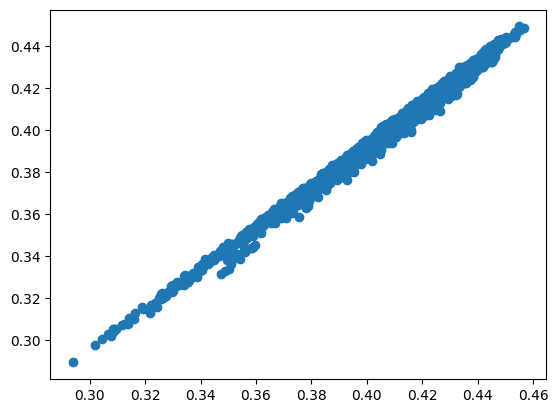

In [13]:
import matplotlib.pyplot as plt
# plt.subplot()
# plt.scatter(x=impact_tfidf["impact-1.0"],y=impact_doc2vec["impact-1.0"])
# plt.show()

# plt.scatter(x=impact_doc2vec["impact-1.0"],y=impact_doc2vec["impact-3.0"])
# plt.show()

plt.scatter(x=impact_doc2vec["novelty-1.0"],y=impact_doc2vec["novelty-3.0"])
plt.show()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])